# Class Preprocessiong

# Code

In [22]:
from ps_estimator import pstimator 
import bandpowers
import utils

In [975]:
sys.getsizeof?

In [514]:
import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import imp
import camb

from astropy.io import fits as fits

from scipy.linalg import sqrtm

from numpy import linalg as LA
%matplotlib inline

In [3]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

In [583]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
lbin = len(leff)
b_ind = np.arange(1,lbin+1)

In [580]:
ali_ma = hp.read_map('/fnx/jianyao/Likelihood_data/ABSData/ali_mask.fits', field = None)

NSIDE = 128
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


## window function

 equal weight for each $\ell$ in a $\ell$-bin
 
 for bin_width = 20, weight = 1/20 = 0.05

### code

In [45]:
b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
nb = len(leff)
for i in range(nb):

    bpwf = np.zeros(lmax-lmin+2)
    lrange = b.get_ell_list(i)
    w = b.get_weight_list(i) ## weights for each ell in i-th bin
    bpwf[lrange-lmin+1] = w
    l = np.arange(1, lmax-lmin+3)

    bpwf = np.array([l, bpwf]).T
    
    # print(np.shape(bpwf))
    # np.savetxt(data_dir+'AliCPT_bpwf_bin%s.txt'%(i+1), bpwf, fmt=['%d', '%.10e', '%.10e', '%.10e'])
    # np.savetxt(data_dir + 'AliCPT_bpwf_bin%s.txt' % (i + 1), bpwf, fmt=['%d', '%.10e', '%.10e', '%.10e', '%.10e', '%.10e', '%.10e'])
#     np.savetxt(data_dir+'AliCPT_bpwf_bin%s.txt'%(i+1), bpwf, fmt=['%d', '%.10e'])

##  $C_{\ell}^b$ : fiducial bandpower for each $\ell$-bin, using Window function. or theoretical ?? 

> cl_fiducial_file = AliCPT_fiducial.dat

39x1, assuing cross power spectra for different frequencies are the same 

cl_diducial_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

In [859]:
cl_f_all = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_f_all.npy')

In [860]:
cl_f = np.mean(cl_f_all, axis = 0)

In [887]:
Nf = cl_f.shape[2]

nf_ind = int(Nf*(Nf+1)/2)

In [861]:
cl_f.shape

(3, 10, 2, 2)

## $C\ell_{th}$ =$ C\ell_\rm{CAMB} + N\ell$

In [865]:
cl_camb = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_camb_BB_2fre.npy')

In [866]:
nl_all = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/nl_all.npy')
nl_mean = np.mean(nl_all, axis = 0) ## EE EB BB

In [867]:
cl_th_BB = cl_camb + nl_mean[2]

## $\hat {C}_{\ell} $ : observed data.

cl_hat_file = AliCPT_cl_hat.dat 

39x7 (first line is \ell bin, what remain are cross bandpowers bwtween frequencies)

cl_hat_order = Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

In [856]:
### 观测数据应该只有一幅。。。

cl_hat_all = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_hat_all.npy')
cl_hat = np.mean(cl_hat_all, axis = 0)

In [857]:
SamNum = 500

In [869]:
print('cl_th_BB.shape:',cl_th_BB.shape, '\n'
      
      'cl_hat.shape:',cl_hat.shape)

cl_th_BB.shape: (10, 2, 2) 
cl_hat.shape: (3, 10, 2, 2)


The description below is taken from Section 9 of Barkats <i>et al.</i> (2014). More mathematical details can be found in Section II. E of Hamimeche & Lewis (2008), where it is shown that, while the likelihood approximation is only exact on the full sky, it remains good enough on cut-sky analyses like BICEP at $\ell>30$.

The likelihood approximation is

$$-2\log\mathcal{L}(\mathcal{D}_b\mid\hat{\mathcal{D}}_b)=X_c\mathcal{M}_{cc'}^{-1}X_{c'},$$

where $\mathcal{D}_b$ are the model bandpowers and $\hat{\mathcal{D}}_b$ are the data. The indices $c$ and $c'$ run over combinations of $\ell$-bins and six spectra ($TT$, $EE$, $BB$, $TE$, $EB$, and $TB$), while $b$ runs over $\ell$-bins only.

This is a quadratic likelihood that looks similar to a $\chi^2$, however the vector $X_c$ here is not the vector of bandpowers themselves but rather a transformed version of the bandpowers, where the transformation is designed to correct the shape of the likelihood (Section II. E. of Hamimeche & Lewis, 2008):

$$\left(X_b^{TT}, X_b^{EE}, X_b^{BB}, X_b^{TE}, X_b^{EB}, X_b^{TB}\right)=\textrm{vecp}\left((\mathcal{D}_b^f)^{1/2}{\bf U}_b\,g({\bf D}_b){\bf U}_b^{\dagger}(\mathcal{D}_b^f)^{1/2}\right)$$

In this expression, $\mathcal{D}_b^f$ are fiducial bandpowers from the mean of $\Lambda$CDM signal-plus-noise simulations (the same simulations used to calculate the bandpower covariance $\mathcal{M}_{cc'}$. Matrices ${\bf U}_b$ and ${\bf D}_b$ are the eigenvectors and eigenvalues of the matrix product ${\bf\mathcal{D}}^{-1/2}_b{\bf\hat{\mathcal{D}}}_b{\bf\mathcal{D}}^{-1/2}_b$, and the function

$$g(x)\equiv{\rm sign}(x-1)\sqrt{2(x-\ln x-1)}$$

acts on the diagonal matrix ${\bf D}_b$ to form $g({\bf D}_b)$.

$$\left(X_b^{30*30}, X_b^{95*95}, X_b^{150*150}, X_b^{353*353}, X_b^{30*95}, X_b^{95*150},X_b^{150*353},X_b^{30*150},X_b^{95*353},X_b^{30*353} \right)=\textrm{vecp}\left((\mathcal{D}_b^f)^{1/2}{\bf U}_b\,g({\bf D}_b){\bf U}_b^{\dagger}(\mathcal{D}_b^f)^{1/2}\right)$$

### cl_th

In [259]:
cl_th[5]

array([[0.00719672, 0.00719672, 0.00719672, 0.00719672],
       [0.00719672, 0.00719672, 0.00719672, 0.00719672],
       [0.00719672, 0.00719672, 0.00719672, 0.00719672],
       [0.00719672, 0.00719672, 0.00719672, 0.00719672]])

In [288]:
e, E = LA.eig(cl_th[5])

$ A = E \Sigma E^{T}$ ; $A^{-1} = E \Sigma ^{-1} E^{T}$ $

In [289]:
np.dot(E, np.dot(np.diag(e), E.T))

array([[0.00719672, 0.00719672, 0.00719672, 0.00719672],
       [0.00719672, 0.00719672, 0.00719672, 0.00719672],
       [0.00719672, 0.00719672, 0.00719672, 0.00719672],
       [0.00719672, 0.00719672, 0.00719672, 0.00719672]])

In [294]:
E[:,0]  = 0; E[:,2] = 0; E[:,3] = 0; e[0] = 0; e[2] = 0; e[3] = 0; e[1] = 1.0/e[1]

In [295]:
np.dot(E, np.dot(np.diag(e), E.T))

array([[8.68450901, 8.68450901, 8.68450901, 8.68450901],
       [8.68450901, 8.68450901, 8.68450901, 8.68450901],
       [8.68450901, 8.68450901, 8.68450901, 8.68450901],
       [8.68450901, 8.68450901, 8.68450901, 8.68450901]])

In [272]:
LA.pinv(cl_th[5])

array([[8.68450901, 8.68450901, 8.68450901, 8.68450901],
       [8.68450901, 8.68450901, 8.68450901, 8.68450901],
       [8.68450901, 8.68450901, 8.68450901, 8.68450901],
       [8.68450901, 8.68450901, 8.68450901, 8.68450901]])

In [316]:
np.real(sqrtm(LA.pinv(cl_th[5])))

array([[1.47347455, 1.47347454, 1.47347455, 1.47347455],
       [1.47347455, 1.47347457, 1.47347454, 1.47347454],
       [1.47347455, 1.47347454, 1.47347455, 1.47347455],
       [1.47347455, 1.47347454, 1.47347455, 1.47347455]])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

### cl_f

${\bf\mathcal{D}}^{-1/2}_b{\bf\hat{\mathcal{D}}}_b{\bf\mathcal{D}}^{-1/2}_b$

In [450]:
nmatrix = np.random.normal(size = (5,500))
nmat = np.cov(nmatrix)

LA.eigvals(nmat)

array([0.84016461, 0.88510838, 1.12898492, 1.06727341, 1.02693974])

### Integrage BICEP's code

## Bandpower covariance matrix

10 bins, 10-fre cross, SamNum BB

> /home/yao/Desktop/likelihood/ali_joint_analysis/CosmoMC_AliCPT/data/AliCPT_Plk/AliCPT_covmat.dat

$234 \times 234$

(39x6) * (39x6)

39-bin; bin_width = 20, nmtlmax = 800 

Ali_95_BxAli_95_B Ali_95_BxAli_150_B Ali_95_BxAli_353_B Ali_150_BxAli_150_B Ali_150_BxAli_353_B Ali_353_BxAli_353_B

### Get arrays for Covariance matrix

In [884]:
def Marray_lfirst(nf_ind, Nmode,lbin, SamNum, cl_f_all):
    
    '''
    Input
    --------------------------------
    nf_ind : number of independent frequencies cross
    Nmode: number of modes, e.g., EE,EB,BB
    SamNum: number of realizations
    cl_hat_all: cl_hat that consists of all the realizations (20, 3, 10, 4, 4);(SamNum, Nmode, lbin, Nf, Nf)
    
    Output
    --------------------------------
    
    '''  
    vecp = utils.vecp
    marray = np.zeros(((lbin*Nmode*nf_ind), SamNum)) # mode(EE, EB, BB), l-bin, nf independent corr between frequencies 
    for n in range(SamNum):

        for ell in range(lbin):

            cl_flat = np.zeros((Nmode, nf_ind)) ## collect independent corr for each mode

            for mode in range(Nmode):

                cl_flat[mode] = vecp(cl_f_all[n][mode][ell])

            marray[ell*Nmode*nf_ind:(ell+1)*Nmode*nf_ind,n] = cl_flat.flatten()
    
    return marray

In [913]:
nl_mean.shape

(3, 10, 2, 2)

In [916]:
cl_f_all[n][mode][ell].shape

(2, 2)

In [984]:
vecp = utils.vecp

In [994]:
def Marray_EEfirst(nf_ind, Nmode,lbin, SamNum, cl_f_all):

    marray = np.zeros(((Nmode*lbin*nf_ind), SamNum)) # mode(EE, EB, BB), l-bin, nf independent corr between frequencies 
    for n in range(SamNum):

        for mode in range(Nmode):    

            cl_flat = np.zeros((lbin, nf_ind)) ## collect independent corr for each l-bin

            for ell in range(lbin):
                cl_flat[ell] = vecp(cl_f_all[n][mode][ell])# - nl_mean[2][ell] ) ##########!!!!!!!!!!!!!!!!!! need to subtract noise?? 06.27

            marray[mode*lbin*nf_ind:(mode+1)*lbin*nf_ind,n] = cl_flat.flatten()
            
    return marray

### Figures

In [116]:
marry = Marray_EEfirst(4, 3, 10, cl_hat_all.shape[0], cl_hat_all)

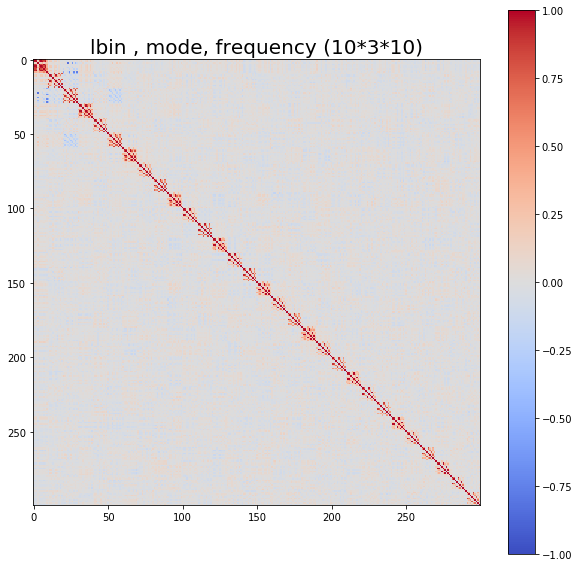

In [115]:
cov_marry = np.corrcoef(marry)
plt.figure(figsize = (10,10))
plt.imshow(cov_marry, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()
plt.title('lbin , mode, frequency (10*3*10)', fontsize = 20)
plt.savefig('./fig_results/covariance_matrix_lbin_first.pdf', format = 'pdf')

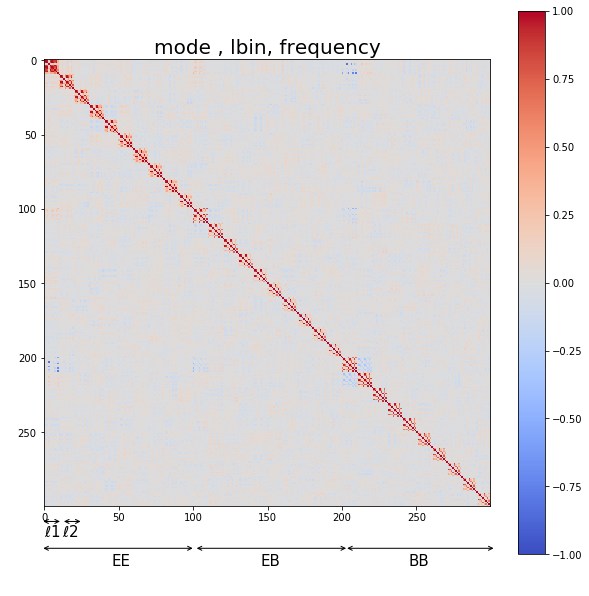

In [117]:
cov_marry = np.corrcoef(marry)
plt.figure(figsize = (10,10))
plt.imshow(cov_marry, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()
plt.title('mode , lbin, frequency', fontsize = 20)
plt.annotate(s = '',xy=(0.07,0.08), xytext=(0.33,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.33,0.08), xytext=(0.59,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.585,0.08), xytext=(0.84,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.text(45, 340, 'EE', fontsize = '15')
plt.text(145, 340, 'EB', fontsize = '15')
plt.text(245, 340, 'BB', fontsize = '15')

plt.annotate(s = '',xy=(0.07,0.125), xytext=(0.105,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.105,0.125), xytext=(0.140,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')

plt.text(0, 320, '$\ell$1', fontsize = '15')
        
plt.text(12, 320, '$\ell$2', fontsize = '15')
          
plt.savefig('./fig_results/covariance_matrix_EE_first.pdf', format = 'pdf')

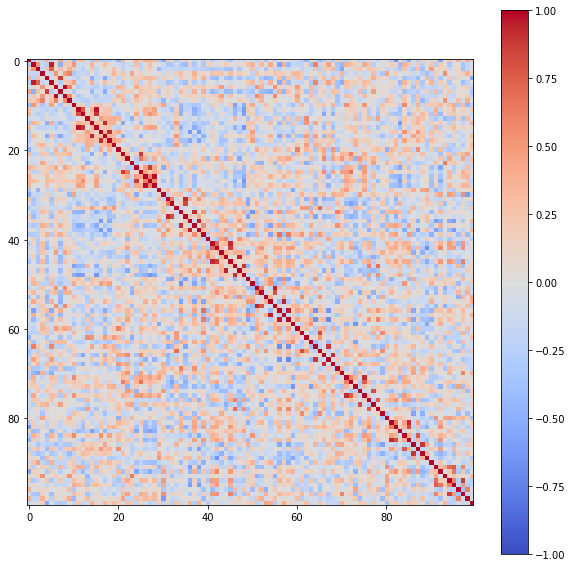

In [35]:
## 20 realizations

plt.figure(figsize = (10,10))
plt.imshow(cov_mat_BB, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()

In [489]:
marry.shape

(300, 500)

In [33]:
cov_mat =  np.corrcoef(marray)## full covariance matrix
# 
# np.corrcoef(marray)

Text(12, 320, '$\\ell$2')

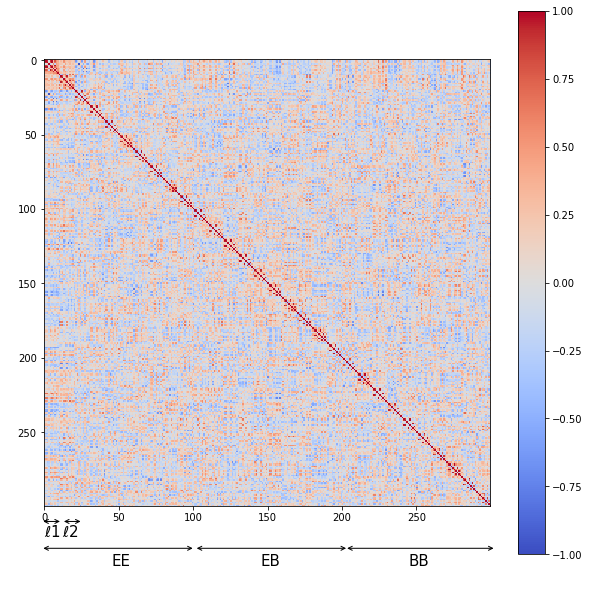

In [34]:
plt.figure(figsize = (10,10))
plt.imshow(cov_mat, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.colorbar()
# plt.text(0,-5,'EE')
# plt.xticks([100], 'hh')
# plt.xlim(-10, 310)
# plt.ylim(-10, 310)

plt.annotate(s = '',xy=(0.07,0.08), xytext=(0.33,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.33,0.08), xytext=(0.59,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.585,0.08), xytext=(0.84,0.08),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.text(45, 340, 'EE', fontsize = '15')
plt.text(145, 340, 'EB', fontsize = '15')
plt.text(245, 340, 'BB', fontsize = '15')

plt.annotate(s = '',xy=(0.07,0.125), xytext=(0.105,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')
plt.annotate(s = '',xy=(0.105,0.125), xytext=(0.140,0.125),arrowprops=dict(arrowstyle='<->'), xycoords = 'figure fraction')

plt.text(0, 320, '$\ell$1', fontsize = '15')
plt.text(12, 320, '$\ell$2', fontsize = '15')

### calculate the covariance matrix

In [978]:
cl_f_all.shape

(500, 3, 10, 2, 2)

In [993]:
cl_f_all[100][2][5]

array([[0.01306182, 0.00747036],
       [0.00747036, 0.01357048]])

3

In [982]:
lbin

10

In [995]:
#(Nf, Nmode,lbin, SamNum, cl_hat_all)

marry = Marray_EEfirst(nf_ind, 3, lbin, cl_f_all.shape[0], cl_f_all)

In [996]:
marry.shape

(90, 500)

In [997]:
marry[60:90,100][15:18]

array([0.01306182, 0.01357048, 0.00747036])

In [999]:
marry[lbin*nf_ind*2:].shape

(30, 500)

In [981]:
lbin*nf_ind*2

60

In [920]:
cov_mat_BB = np.cov(marry[lbin*nf_ind*2:])

In [921]:
cov_mat_BB.shape ##10-lbin*10-frequency combination

(30, 30)

### reorganize M_inv to (lbin, lbin, nf_ind, nf_ind)for the Likelihood calculation 

##### for EE first

In [557]:
cov_mat_inv = LA.inv(cov_mat_BB)
M_inv = np.ones((lbin, lbin, nf_ind, nf_ind))

### for EE first

for ell in range(lbin*nf_ind):
    i = ell//10; j = ell%10;
    for fre in range(nf_ind):
        
        M_inv[i, j] = np.triu(cov_mat_inv[ell, nf_ind*fre:nf_ind*(fre+1)])
        
## only BB

##### for l-bin first

In [965]:
cov_mat_inv.shape

(30, 30)

In [1002]:
cov_mat_inv = LA.inv(cov_mat_BB)
M_inv = np.ones((lbin, lbin, nf_ind, nf_ind))

for l in range(lbin):
    
    for lp in range(lbin):
        
        M_inv[l,lp, :, :] = cov_mat_inv[l*nf_ind:(l+1)*nf_ind, lp*nf_ind:(lp+1)*nf_ind]

### Test for  Likelihood

#### BB mode

In [649]:
def GenBB(r = 0.05, raw_cl = True):
    '''
    Generate the theoretical power spectra using camb
    '''
    
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.26, ombh2=0.022, omch2=0.1199, mnu=0.06, omk=0, tau=0.078)
    pars.InitPower.set_params(As=2.19856*1e-9, ns=0.9652, r = r)
    pars.set_for_lmax(3000, lens_potential_accuracy=1)
    pars.WantTensors = True
    
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=raw_cl)
    
    totCL=powers['tensor'] ## TT EE BB TE
#     ell = np.arange(len(totCL.T[0]))
    return totCL.T[2]

In [626]:
r = 0.05

In [681]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.26, ombh2=0.022, omch2=0.1199, mnu=0.06, omk=0, tau=0.078)
pars.InitPower.set_params(As=2.19856*1e-9, ns=0.9652, r = 0)
pars.set_for_lmax(3000, lens_potential_accuracy=1)
pars.WantTensors = True

results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True)

In [682]:
total = powers['total']

In [656]:
bb = GenBB(0.05, raw_cl=False)
bb_06 = GenBB(0.06, raw_cl=False)

/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


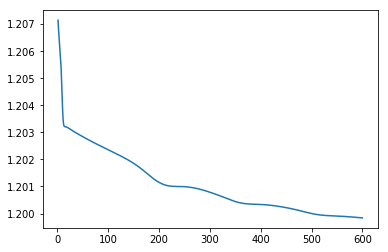

In [659]:
plt.plot(bb_06/bb)

In [691]:
nl_mean[2][:,1,1]

array([0.00219406, 0.00042306, 0.0008092 , 0.00138481, 0.0021608 ,
       0.00313533, 0.00429503, 0.00563341, 0.00718524, 0.00949875])

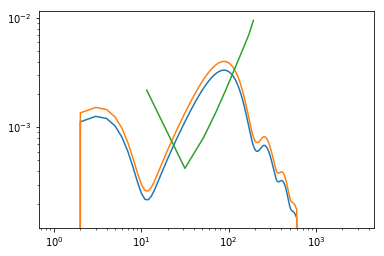

In [697]:
# plt.loglog(total[:,2])
plt.loglog(bb)
plt.loglog(bb_06)

plt.loglog(est.ell_n, nl_mean[2][:,1,1])

#### evaluate L 

BB cross-frequency bandpower spectra

- Cl_hat : (lbin, Nf, Nf)

- Cl_f :  ((lbin, Nf, Nf))

- Cl_th : ((lbin, Nf, Nf))

In [900]:
cl_hat_0 = cl_hat_all[1]

In [897]:
print('Cl_hat:',cl_hat_0.shape)
print('Cl_f:',cl_f.shape)
print('Cl_th_BB:',cl_th_BB.shape)

Cl_hat: (3, 10, 2, 2)
Cl_f: (3, 10, 2, 2)
Cl_th_BB: (10, 2, 2)


def evaluateLikelihood(C_l,C_l_hat,C_fl,M_inv)

In [1012]:
rlist = np.arange(0, 0.1, 0.0001)

In [803]:
evaluateL = utils.evaluateLikelihood

In [660]:
bb_05 = GenBB(0.05, raw_cl = True) ##only tensor BB

In [1014]:
# Initiating the logarithmic likelihood arrays
logLike = np.zeros(len(rlist))

# loop over r values
for i in range(len(rlist)):
   
    r_i  =  rlist[i]
    bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 
    
    bb_camb = bb_tensor + total[:,2][0:nmtlmax+1] ## tensor BB + lensing BB 
        
    cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
    cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
    for ell in range(lbin):
        cl_th_test[ell] *= cl_th_i[ell]
    
    # add Noise bias N_l to expectation values.
    C_l = cl_th_test + nl_mean[2]

    logL = evaluateL(C_l, cl_hat_0[2], cl_f[2], M_inv)
    logLike[i] = np.real(logL)

In [1042]:
logLike[513]

-19.77144475316422

In [1029]:
logLike[530]

-18.75259158244029

In [1035]:
logLike[548]

-19.748406175718053

In [1030]:
rlist[530]

0.053000000000000005

In [1036]:
rlist[548]

0.0548

In [1043]:
rlist[513]

0.051300000000000005

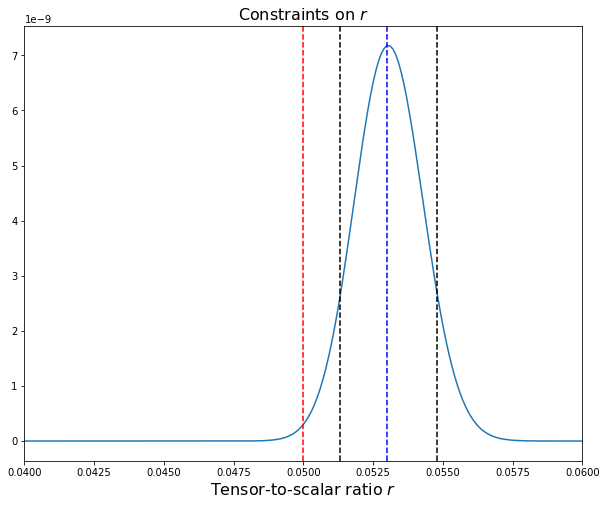

In [1049]:
plt.figure(figsize = (10, 8))
plt.plot(rlist, np.exp(logLike))
# plt.yscale('log')
plt.axvline(0.05, c='r', ls='--')

plt.axvline(rlist[513], c='k', ls='--')

plt.axvline(rlist[548], c='k', ls='--')

plt.axvline(rlist[530], c='b', ls='--')


plt.xlim([0.04, 0.06])
# plt.ylim([0, 0.07])
# plt.yticks([])
plt.xlabel(r'Tensor-to-scalar ratio $r$', size=16)
# plt.ylabel(r'Probability', size=16)
plt.title(r'Constraints on $r$', size=16)
# plt.text(0.052, 1.0, 'r = 0.05', fontsize = 20)
plt.show()